In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from itertools import izip

In [2]:
import numpy as np

import tensorflow as tf
# import tensorflow.contrib as tfcontrib
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
# from tensorflow.python.keras import backend as K

import time

//anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Read 256x256 images in directory

We will set up our training data generator to do image augmentation, and the validation data generator **not** to do augmentation, which is the default behavior of the `ImageDataGenerator` class.

In [3]:
print(time.asctime(time.localtime()))

# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

# I guess everything defaults to false here. 
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

Wed Oct 10 19:15:23 2018


# Make the generators

Provide the same seed and keyword arguments to the flow methods for image and mask generators to ensure we get the same data augmentation performed for a given image and its associated mask.

### NOTE:
I had to modify the source code for tensorflow to get 16-bit images to read in correctly. My problem was that the pixel intensity values of all my 16-bit images, after reading in, were truncated to 255! 

Following the suggestion by jfx319 [here](https://github.com/keras-team/keras/issues/4486), I modified tensorflow's image.py code in `load_img` from:

```python
if grayscale:
    if img.mode != 'L':
        img = img.convert('L')
```

to now be:

```python
if grayscale:
    img = img.convert('I')
```

That seems to be a fine fix.

If you're not sure where to find tensorflow's image.py, I recommend running the following from your command line:

```bash
locate image.py | grep tensorflow

In [4]:
# ImageDataGenerator??

In [5]:
print(time.asctime(time.localtime()))

seed = 1
batch_size = 5
train_image_generator = train_image_datagen.flow_from_directory(
    'shift35_imgs/train/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'shift35_imgs/train/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
# had to change this to iterator zip as otherwise it gives a big memory error. 
train_generator = izip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'shift35_imgs/val/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'shift35_imgs/val/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
val_generator = izip(val_image_generator, val_mask_generator)

Wed Oct 10 19:15:23 2018
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [6]:
print(time.asctime(time.localtime()))

Wed Oct 10 19:15:24 2018


# Build the model using keras

In [7]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

## This model architecture is called U-net. It is simple, but it seems to work really, really well for phase-contrast mother machine images!

In [8]:
print(time.asctime(time.localtime()))

inputs = layers.Input(shape=(256,256,1))
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 128)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

Wed Oct 10 19:15:24 2018


In [9]:
print(time.asctime(time.localtime()))

model = models.Model(inputs=[inputs], outputs=[outputs])

Wed Oct 10 19:15:25 2018


## Define functions for loss metrics

This is ripped straight off of this [tutorial](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb), in the **Defining custom metrics and loss functions** section.

In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile the model and show us its structure

In [11]:
print(time.asctime(time.localtime()))

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

Wed Oct 10 19:15:25 2018
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________

In [12]:
print(time.asctime(time.localtime()))

save_model_path = 'weights_20181010_e50.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', 
                                        save_best_only=True, verbose=1)

Wed Oct 10 19:15:25 2018


In [13]:
epochs = 50

## Train the sucker!
* Note that the steps per epoch should be enough to get through your dataset. 

In [14]:
print(time.asctime(time.localtime()))

# note the numbers for the steps are the number of images imported 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(80/float(batch_size))),
    epochs=epochs,
    callbacks=[cp],
    validation_data=val_generator,
    validation_steps=int(np.ceil(20/float(batch_size))))

Wed Oct 10 19:15:25 2018
Epoch 1/50
15/16 [===========================>..] - ETA: 9s - loss: 1.4564 - dice_loss: 0.9283 
Epoch 00001: val_dice_loss improved from inf to 0.96490, saving model to weights_20181010_e50.hdf5
16/16 [==============================] - 160s 10s/step - loss: 1.4407 - dice_loss: 0.9260 - val_loss: 1.9203 - val_dice_loss: 0.9649
Epoch 2/50
15/16 [===========================>..] - ETA: 8s - loss: 1.1555 - dice_loss: 0.8880 
Epoch 00002: val_dice_loss did not improve from 0.96490
16/16 [==============================] - 144s 9s/step - loss: 1.1538 - dice_loss: 0.8882 - val_loss: 1.3488 - val_dice_loss: 0.9816
Epoch 3/50
15/16 [===========================>..] - ETA: 8s - loss: 1.0747 - dice_loss: 0.8636 
Epoch 00003: val_dice_loss did not improve from 0.96490
16/16 [==============================] - 144s 9s/step - loss: 1.0730 - dice_loss: 0.8632 - val_loss: 1.3114 - val_dice_loss: 0.9841
Epoch 4/50
15/16 [===========================>..] - ETA: 8s - loss: 1.0175 - di

Epoch 27/50
15/16 [===========================>..] - ETA: 8s - loss: 0.1312 - dice_loss: 0.1201 
Epoch 00027: val_dice_loss did not improve from 0.11652
16/16 [==============================] - 146s 9s/step - loss: 0.1315 - dice_loss: 0.1203 - val_loss: 0.9681 - val_dice_loss: 0.8170
Epoch 28/50
15/16 [===========================>..] - ETA: 8s - loss: 0.1338 - dice_loss: 0.1219 
Epoch 00028: val_dice_loss did not improve from 0.11652
16/16 [==============================] - 147s 9s/step - loss: 0.1332 - dice_loss: 0.1213 - val_loss: 1.9819 - val_dice_loss: 0.9042
Epoch 29/50
15/16 [===========================>..] - ETA: 8s - loss: 0.1299 - dice_loss: 0.1184 
Epoch 00029: val_dice_loss did not improve from 0.11652
16/16 [==============================] - 3740s 234s/step - loss: 0.1302 - dice_loss: 0.1186 - val_loss: 2.6861 - val_dice_loss: 0.9033
Epoch 30/50
15/16 [===========================>..] - ETA: 6:59 - loss: 0.1267 - dice_loss: 0.1148 
Epoch 00030: val_dice_loss did not improve 

## Visualize the model's fit.
Basically, training loss will always diminish as epochs go by. Once the validation loss stops going down and starts going back up, that's when you're overfitting for your particular dataset.

Thu Oct 11 10:45:46 2018


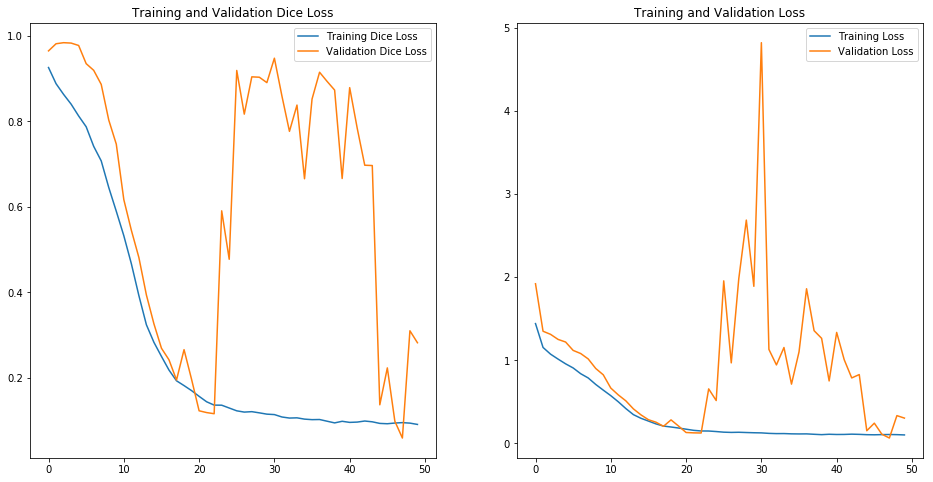

In [15]:
print(time.asctime(time.localtime()))

dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()